# Analyze snowline change by terrain characteristics: elevation, slope, aspect

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
import glob
import os
from scipy.stats import iqr
import cmocean

base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
study_sites_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/'
figures_out_path = study_sites_path+'../../write-ups/GSA_Cordilleran_2023/figures/'

## Plot snow cover statistics for each site

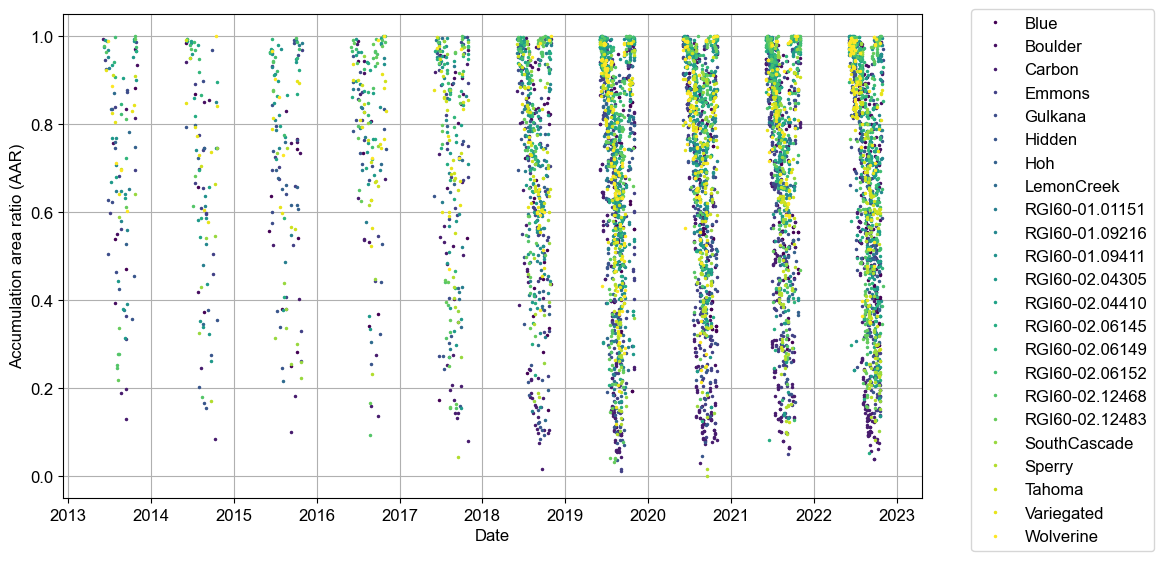

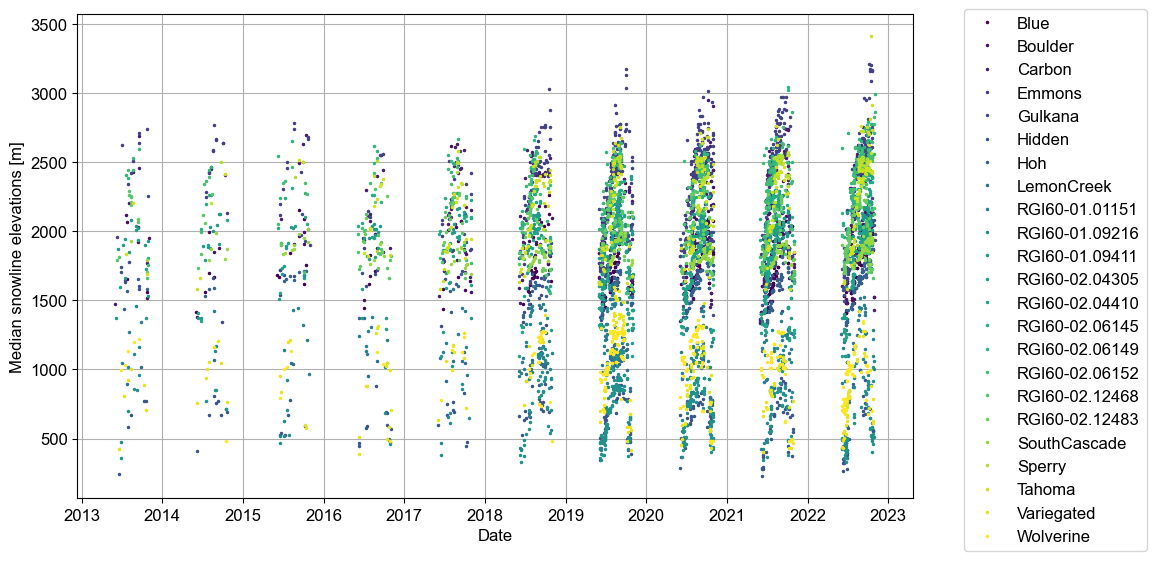

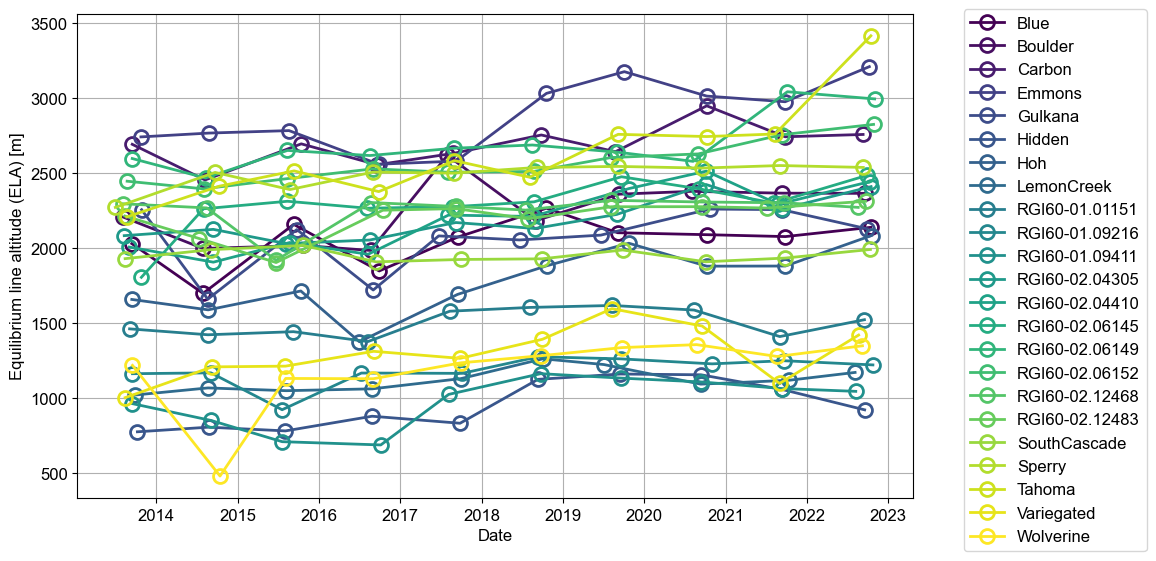

In [31]:
# -----Grab all study-site names
site_names = sorted([x for x in os.listdir(study_sites_path) if '.DS_Store' not in x])

# -----Set up figures
# AAR
fig1, ax1 = plt.subplots(1, 1, figsize=(12,6))
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
ax1.grid()
ax1.set_xlabel('Date')
ax1.set_ylabel('Accumulation area ratio (AAR)')
# Median snowline elevations
fig2, ax2 = plt.subplots(1, 1, figsize=(12,6))
ax2.grid()
ax2.set_xlabel('Date')
ax2.set_ylabel('Median snowline elevations [m]')
# ELAs
fig3, ax3 = plt.subplots(1, 1, figsize=(12,6))
ax3.grid()
ax3.set_xlabel('Date')
ax3.set_ylabel('Equilibrium line altitude (ELA) [m]')
# define color map for each site
cmap = plt.cm.viridis

# loop through sites
for i, site_name in enumerate(site_names):
        
    # check if filtered snowlines exist in directory
    snowlines_path = study_sites_path + site_name + '/imagery/snowlines/'
    snowlines_fn = glob.glob(snowlines_path + '*filtered_snowlines.csv')
    if len(snowlines_fn)>0:
        snowlines_df = pd.read_csv(snowlines_fn[0])
        snowlines_df['datetime'] = snowlines_df['datetime'].astype('datetime64[ns]')
        # set minimum snowline elevations to NaNs
        snowlines_df.loc[snowlines_df['snowlines_elevs_median_m']==np.nanmin(snowlines_df['snowlines_elevs_median_m']), 
                         'snowlines_elevs_median_m'] = np.nan
        # remove NaN rows
        snowlines_df = snowlines_df.dropna()
        
        # load ELAs
        ELAs_fn = glob.glob(snowlines_path+'*ELAs*.csv')[0]
        ELAs = pd.read_csv(ELAs_fn)
        ELAs['datetime'] = ELAs['datetime'].astype('datetime64[ns]')
        # load RGI outline

        # plot statistics over time
        ax1.plot(snowlines_df.datetime.values, snowlines_df.AAR, 
                 '.', markersize=3, color=cmap(i/(len(site_names)-1)), label=site_name)
        ax2.plot(snowlines_df.datetime.values, snowlines_df.snowlines_elevs_median_m, 
                 '.', markersize=3, color=cmap(i/(len(site_names)-1)), label=site_name)
        ax3.plot(ELAs.datetime.values, ELAs.ELA_m, 'o-', 
                 markersize=10, markeredgewidth=2, color=cmap(i/(len(site_names)-1)), linewidth=2,
                 markeredgecolor=cmap(i/(len(site_names)-1)), markerfacecolor='None', label=site_name)

ax1.legend(loc='center right', bbox_to_anchor=[1.08, 0.35, 0.2, 0.2])
ax2.legend(loc='center right', bbox_to_anchor=[1.09, 0.35, 0.2, 0.2])
ax3.legend(loc='center right', bbox_to_anchor=[1.09, 0.35, 0.2, 0.2])
fig1.tight_layout()
fig2.tight_layout()
fig3.tight_layout()

plt.show()

# save figures
fig1.savefig(figures_out_path+'timeseries_AARs.png', facecolor='w', dpi=300, bbox_inches='tight')
fig2.savefig(figures_out_path+'timeseries_snowline_elevations.png', facecolor='w', dpi=300, bbox_inches='tight')
fig3.savefig(figures_out_path+'timeseries_ELAs.png', facecolor='w', dpi=300, bbox_inches='tight')


## Load RGI data and snowline timeseries

In [3]:
# -----Grab all study-site names
site_names = sorted([x for x in os.listdir(study_sites_path) if '.DS_Store' not in x])

# -----Loop through sites
RGIs = pd.DataFrame() # initialize full RGI df
for site_name in site_names:
    
    print(site_name)
    
    # check if filtered snowlines exist in directory
    snowlines_path = study_sites_path + site_name + '/imagery/snowlines/'
    snowlines_fn = glob.glob(snowlines_path + '*filtered_snowlines.csv')
    if len(snowlines_fn)>0:
        snowlines_df = pd.read_csv(snowlines_fn[0])
        snowlines_df['datetime'] = snowlines_df['datetime'].astype('datetime64[ns]')
        # set minimum snowline elevations to NaNs
        snowlines_df.loc[snowlines_df['snowlines_elevs_median_m']==np.nanmin(snowlines_df['snowlines_elevs_median_m']), 
                         'snowlines_elevs_median_m'] = np.nan
        # remove NaN rows
        snowlines_df = snowlines_df.dropna()
    else:
        print('No filtered snowlines found, skipping...')
        print(' ')
        continue
        
    # load RGI outline
    RGI_path = study_sites_path + site_name + '/AOIs/'
    RGI_fn = glob.glob(RGI_path + '*RGI*outline.shp')[0]
    RGI = gpd.read_file(RGI_fn)
    # load ELAs
    ELAs_fn = glob.glob(snowlines_path+'*ELAs*.csv')[0]
    ELAs = pd.read_csv(ELAs_fn)
    ELAs['datetime'] = ELAs['datetime'].astype('datetime64[ns]')
    # add data to df
    RGI['snowlines_datetime'] = [snowlines_df['datetime'].values]
    RGI['snowlines_elevs_median_m'] = [snowlines_df['snowlines_elevs_median_m'].values]
    RGI['AAR'] = [snowlines_df['AAR'].values]
    RGI['ELAs_dates'] = [ELAs['datetime'].values]
    RGI['ELAs_m'] = [ELAs['ELA_m'].values]
    # concatenate to full RGI df
    RGIs = pd.concat([RGIs, RGI])
    
    print(' ')

# set snowlines_date as index
RGIs.reset_index(drop=True, inplace=True)
# add month column
months=[]
for x in RGIs['snowlines_datetime']:
    months.append([xx.astype('datetime64[M]').astype(int) % 12 + 1 for xx in x])
RGIs['snowlines_month'] = months
# add DOY column
DOYs = []
for x in RGIs['snowlines_datetime']:
    DOYs.append([xx.timetuple().tm_yday for xx in pd.to_datetime(pd.Series(x), format="%Y%m%d")])
RGIs['snowlines_DOY'] = DOYs
# add WOY column
WOYs = []
for x in RGIs['snowlines_datetime']:
    WOYs.append([int(np.fix(xx.timetuple().tm_yday / 7)) for xx in pd.to_datetime(pd.Series(x), format="%Y%m%d")])
RGIs['snowlines_WOY'] = WOYs

Blue
 
Boulder
 
Carbon
 
Coleman
No filtered snowlines found, skipping...
 
Easton
No filtered snowlines found, skipping...
 
Emmons
 
Gulkana
 
Hidden
 
Hoh
 
LemonCreek
 
Mendenhall
No filtered snowlines found, skipping...
 
RGI60-01.01151
 
RGI60-01.09216
 
RGI60-01.09411
 
RGI60-02.04305
 
RGI60-02.04410
 
RGI60-02.06145
 
RGI60-02.06149
 
RGI60-02.06152
 
RGI60-02.12468
 
RGI60-02.12483
 
SitKusa
No filtered snowlines found, skipping...
 
SouthCascade
 
Sperry
 
Tahoma
 
Variegated
 
Wolverine
 


## Monthly trends in median snowline elevations and AAR by region, average elevation, slope, and aspect

### Region

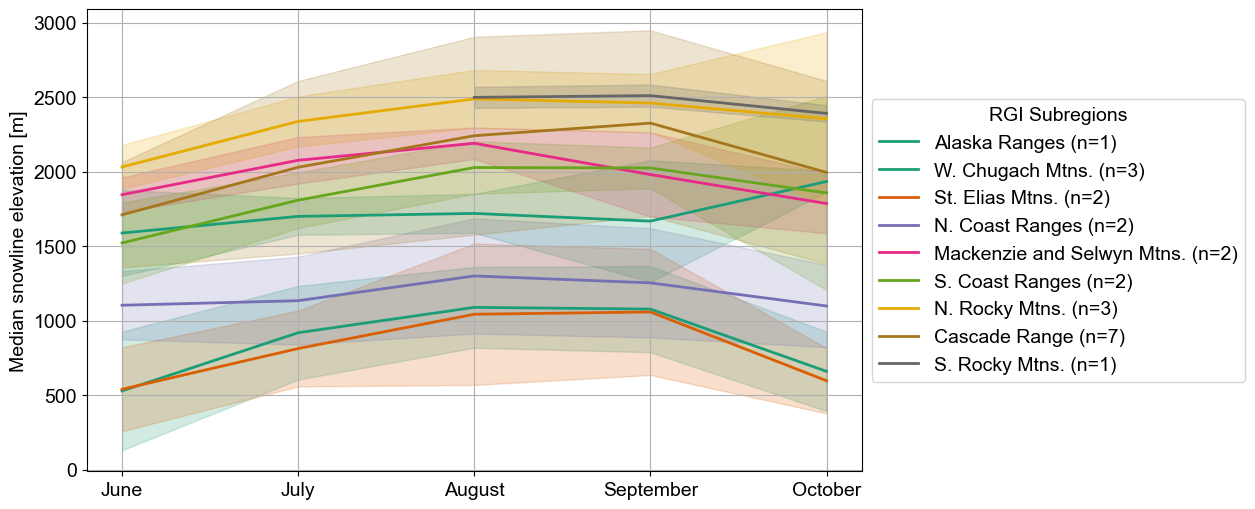

figure saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/../../write-ups/GSA_Cordilleran_2023/figures/monthly_trends_by_region.png


In [4]:
# define region bins
unique_regions = RGIs.groupby(['O1Region', 'O2Region']).size().reset_index().rename(columns={0:'count'}) 

# define colormap for regions
cmap = plt.cm.Dark2

# set up figure
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
ax.grid()
ax.set_ylabel('Median snowline elevation [m]')

# loop through slope bins
for i in range(0, len(unique_regions)):
        
    # subset unique regions
    O1Region = unique_regions.iloc[i]['O1Region']
    O2Region = unique_regions.iloc[i]['O2Region']
    # grab glaciers in bin
    RGIs_region = RGIs.loc[(RGIs['O1Region']==O1Region) & (RGIs['O2Region']==O2Region)]
    if len(RGIs_region)>0:
        # determine name of subregion
        if (O1Region=='1') & (O2Region=='1'):
            region_name='N. Alaska'
        elif (O1Region=='1') & (O2Region=='2'):
            region_name='Alaska Ranges'
        elif (O1Region=='1') & (O2Region=='3'):
            region_name='Aleutians'
        elif (O1Region=='1') & (O2Region=='4'):
            region_name='W. Chugach Mtns.'
        elif (O1Region=='1') & (O2Region=='5'):
            region_name='St. Elias Mtns.'
        elif (O1Region=='1') & (O2Region=='6'):
            region_name='N. Coast Ranges'
        elif (O1Region=='2') & (O2Region=='1'):
            region_name='Mackenzie and Selwyn Mtns.'
        elif (O1Region=='2') & (O2Region=='2'):
            region_name='S. Coast Ranges'
        elif (O1Region=='2') & (O2Region=='3'):
            region_name='N. Rocky Mtns.'
        elif (O1Region=='2') & (O2Region=='4'):
            region_name='Cascade Range' # and Sierra Nevada'
        elif (O1Region=='2') & (O2Region=='5'):
            region_name='S. Rocky Mtns.'
        # print(region_name)
        # grab median snowline elevations and months
        snowlines_elevs_median = np.hstack(RGIs_region['snowlines_elevs_median_m'].values)
        datetimes = np.hstack(RGIs_region['snowlines_datetime'].values)
        months = np.hstack(RGIs_region['snowlines_month'].values)
        # grab all unique months
        unique_months = np.unique(months)
        # initialize variables
        snowlines_elevs_median_month_med = np.zeros(len(unique_months))
        snowlines_elevs_median_month_IQR = np.zeros(len(unique_months))
        # loop through months
        for j, month in enumerate(unique_months):
            # grab all snowline elevations in month
            snowlines_elevs_median_month = snowlines_elevs_median[months==month]
            # calculate means and stds
            snowlines_elevs_median_month_med[j] = np.nanmedian(snowlines_elevs_median_month)
            snowlines_elevs_median_month_IQR[j] = iqr(snowlines_elevs_median_month, nan_policy='omit')
        ax.fill_between(unique_months, snowlines_elevs_median_month_med-snowlines_elevs_median_month_IQR, 
                        snowlines_elevs_median_month_med+snowlines_elevs_median_month_IQR,
                        color=cmap(i/len(unique_regions)), alpha=0.2)
        ax.plot(unique_months, snowlines_elevs_median_month_med, color=cmap(i/len(unique_regions)), linewidth=2,
                label=region_name+' (n='+str(len(RGIs_region))+')')

# adjust axes
ax.set_xticks(range(6,11))
ax.set_xticklabels(['June', 'July', 'August', 'September', 'October'])
ax.legend(title='RGI Subregions', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# save figure
fig_fn = figures_out_path+'monthly_trends_by_region.png'
fig.savefig(fig_fn, facecolor='w', dpi=300, bbox_inches='tight')
print('figure saved to file: '+fig_fn)

### Elevation

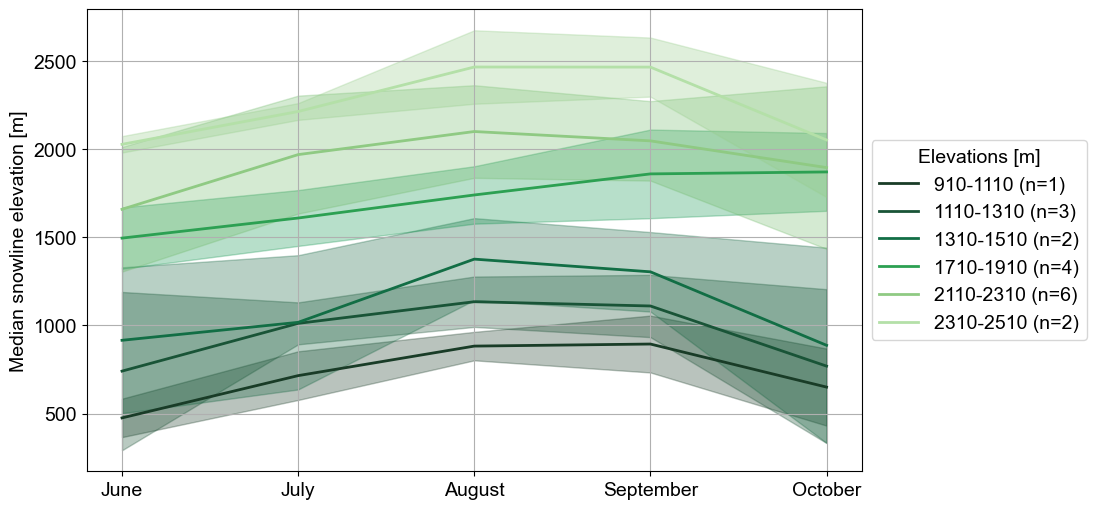

figure saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/../../write-ups/GSA_Cordilleran_2023/figures/monthly_trends_by_elevation.png


In [5]:
# define elevation bins
elev_min, elev_max = np.nanmin(RGIs['Zmed'].values), np.nanmax(RGIs['Zmed'].values)
elev_bins_min, elev_bins_max = np.round(elev_min/10)*10, np.round(elev_max/10)*10+10
elev_bins = np.arange(elev_bins_min, elev_bins_max, step=200)

# define colormap for elevation ranges
cmap = cmocean.cm.algae_r

# set up figure
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
ax.grid()
ax.set_ylabel('Median snowline elevation [m]')

# loop through elevation bins
for i in range(0, len(elev_bins)-1):
    # grab glaciers in bin
    RGIs_elev = RGIs.loc[(RGIs['Zmed'] > elev_bins[i]) & (RGIs['Zmed'] <= elev_bins[i+1])]
    if len(RGIs_elev)>0:
        # grab median snowline elevations and months
        snowlines_elevs_median = np.hstack(RGIs_elev['snowlines_elevs_median_m'].values)
        datetimes = np.hstack(RGIs_elev['snowlines_datetime'].values)
        months = np.hstack(RGIs_elev['snowlines_month'].values)
        # grab all unique months
        unique_months = np.unique(months)
        # initialize variables
        snowlines_elevs_median_month_med = np.zeros(len(unique_months))
        snowlines_elevs_median_month_IQR = np.zeros(len(unique_months))
        # loop through months
        for j, month in enumerate(unique_months):
            # grab all snowline elevations in month
            snowlines_elevs_median_month = snowlines_elevs_median[months==month]
            # calculate means and stds
            snowlines_elevs_median_month_med[j] = np.nanmedian(snowlines_elevs_median_month)
            snowlines_elevs_median_month_IQR[j] = iqr(snowlines_elevs_median_month)
        ax.fill_between(unique_months, snowlines_elevs_median_month_med-snowlines_elevs_median_month_IQR, 
                           snowlines_elevs_median_month_med+snowlines_elevs_median_month_IQR,
                           color=cmap(i/(len(elev_bins))), alpha=0.3)
        ax.plot(unique_months, snowlines_elevs_median_month_med, color=cmap(i/(len(elev_bins)-1)), linewidth=2,
                   label=str(int(elev_bins[i]))+'-'+str(int(elev_bins[i+1]))+' (n='+str(len(RGIs_elev))+')')
        
# adjust axes
ax.set_xticks(range(6,11))
ax.set_xticklabels(['June', 'July', 'August', 'September', 'October'])
ax.legend(title='Elevations [m]', loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

# save figure
fig_fn = figures_out_path+'monthly_trends_by_elevation.png'
fig.savefig(fig_fn, facecolor='w', dpi=300, bbox_inches='tight')
print('figure saved to file: '+fig_fn)

### Slope

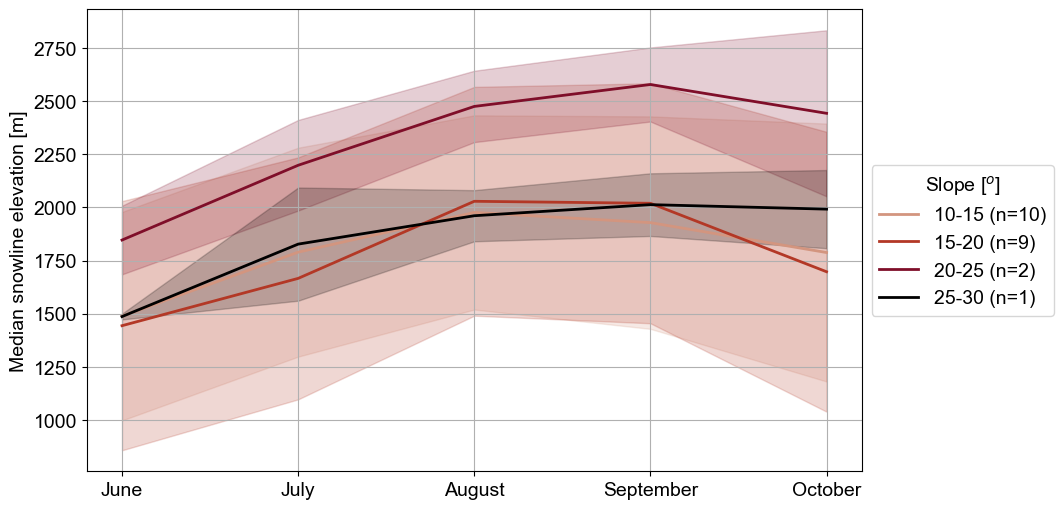

figure saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/../../write-ups/GSA_Cordilleran_2023/figures/monthly_trends_by_slope.png


In [13]:
# define slope bins
slope_min, slope_max = np.nanmin(RGIs['Slope'].values), np.nanmax(RGIs['Slope'].values)
slope_bins_min, slope_bins_max = np.round(slope_min/10)*10, np.round(slope_max/10)*10+10
slope_bins = np.arange(slope_bins_min, slope_bins_max, step=5)

# define colormap for slope bins
cmap = cmocean.cm.amp

# set up figure
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
ax.grid()
ax.set_ylabel('Median snowline elevation [m]')

# loop through slope bins
for i in range(0, len(slope_bins)-2):
    # grab glaciers in bin
    RGIs_slope = RGIs.loc[(RGIs['Slope'] > slope_bins[i]) & (RGIs['Slope'] <= slope_bins[i+1])]
    if len(RGIs_slope)>0:
        # grab median snowline elevations and months
        snowlines_elevs_median = np.hstack(RGIs_slope['snowlines_elevs_median_m'].values)
        datetimes = np.hstack(RGIs_slope['snowlines_datetime'].values)
        months = np.hstack(RGIs_slope['snowlines_month'].values)
        # grab all unique months
        unique_months = np.unique(months)
        # initialize variables
        snowlines_elevs_median_month_med = np.zeros(len(unique_months))
        snowlines_elevs_median_month_std = np.zeros(len(unique_months))
        # loop through months
        for j, month in enumerate(unique_months):
            # grab all snowline elevations in month
            snowlines_elevs_median_month = snowlines_elevs_median[months==month]
            # calculate median and std
            snowlines_elevs_median_month_med[j] = np.nanmedian(snowlines_elevs_median_month)
            snowlines_elevs_median_month_std[j] = np.nanstd(snowlines_elevs_median_month)
        color = [cmap(0.3), cmap(0.6), cmap(0.8), 'k'][i]
        ax.fill_between(unique_months, snowlines_elevs_median_month_med-snowlines_elevs_median_month_std, 
                        snowlines_elevs_median_month_med+snowlines_elevs_median_month_std,
                        color=color, alpha=0.2)
        ax.plot(unique_months, snowlines_elevs_median_month_med, color=color, linewidth=2,
                label=str(int(slope_bins[i]))+'-'+str(int(slope_bins[i+1]))+' (n='+str(len(RGIs_slope))+')')
        
# adjust axes
ax.legend(title='Slope [$^o$]', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(range(6,11))
ax.set_xticklabels(['June', 'July', 'August', 'September', 'October'])
plt.show()

# save figure
fig_fn = figures_out_path+'monthly_trends_by_slope.png'
fig.savefig(fig_fn, facecolor='w', dpi=300, bbox_inches='tight')
print('figure saved to file: '+fig_fn)

### Aspect

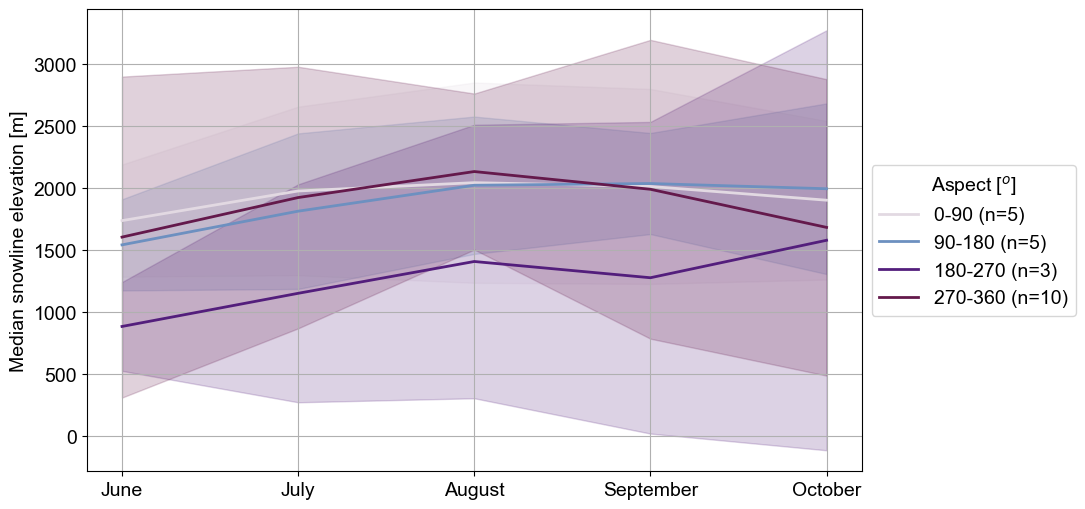

figure saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/../../write-ups/GSA_Cordilleran_2023/figures/monthly_trends_by_aspect.png


In [14]:
# define aspect bins
aspect_bins = np.linspace(0, 360, num=5)

# define colormap for aspect bins
cmap = plt.cm.twilight

# set up figure
fig, ax = plt.subplots(1, 1, figsize=(10,6))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})
ax.grid()
ax.set_ylabel('Median snowline elevation [m]')

# loop through aspect bins
for i in range(0, len(aspect_bins)-1):
    # grab glaciers in bin
    RGIs_aspect = RGIs.loc[(RGIs['Aspect'] > aspect_bins[i]) & (RGIs['Aspect'] <= aspect_bins[i+1])]
    if len(RGIs_aspect)>0:
        # grab median snowline elevations and months
        snowlines_elevs_median = np.hstack(RGIs_aspect['snowlines_elevs_median_m'].values)
        datetimes = np.hstack(RGIs_aspect['snowlines_datetime'].values)
        months = np.hstack(RGIs_aspect['snowlines_month'].values)
        # grab all unique months
        unique_months = np.unique(months)
        # initialize variables
        snowlines_elevs_median_month_med = np.zeros(len(unique_months))
        snowlines_elevs_median_month_IQR = np.zeros(len(unique_months))
        # loop through months
        for j, month in enumerate(unique_months):
            # grab all snowline elevations in month
            snowlines_elevs_median_month = snowlines_elevs_median[months==month]
            # calculate median and std
            snowlines_elevs_median_month_med[j] = np.nanmedian(snowlines_elevs_median_month)
            snowlines_elevs_median_month_IQR[j] = iqr(snowlines_elevs_median_month)
        color = cmap(i/(len(aspect_bins)))
        ax.fill_between(unique_months, snowlines_elevs_median_month_med-snowlines_elevs_median_month_IQR, 
                        snowlines_elevs_median_month_med+snowlines_elevs_median_month_IQR,
                        color=color, alpha=0.2)
        ax.plot(unique_months, snowlines_elevs_median_month_med, color=color, linewidth=2,
                label=str(int(aspect_bins[i]))+'-'+str(int(aspect_bins[i+1]))+' (n='+str(len(RGIs_aspect))+')')
        
# adjust axes
ax.legend(title='Aspect [$^o$]', loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticks(range(6,11))
ax.set_xticklabels(['June', 'July', 'August', 'September', 'October'])
plt.show()

# save figure
fig_fn = figures_out_path+'monthly_trends_by_aspect.png'
fig.savefig(fig_fn, facecolor='w', dpi=300, bbox_inches='tight')
print('figure saved to file: '+fig_fn)

## Plot map of all study sites

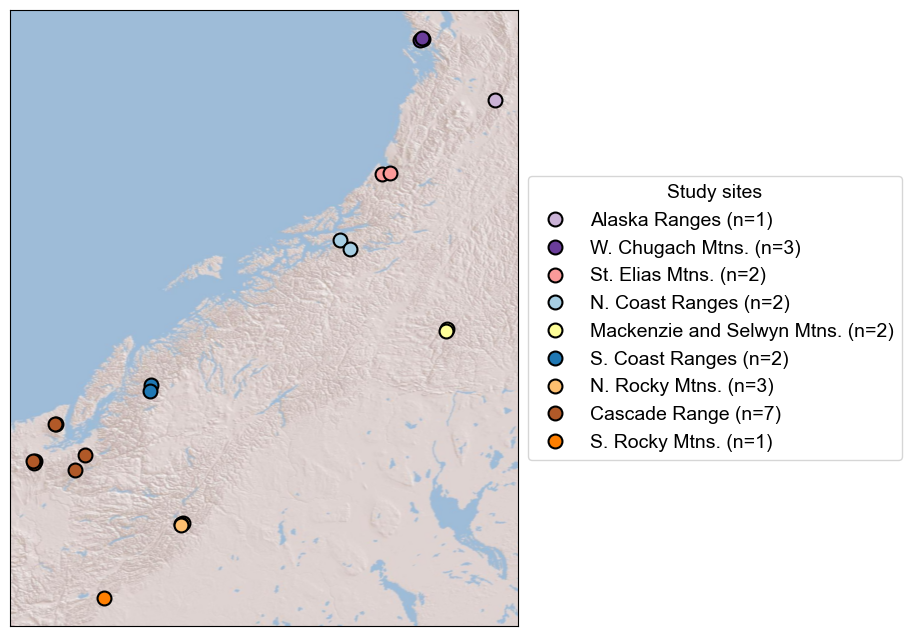

figure saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/../../write-ups/GSA_Cordilleran_2023/figures/study_sites.png


In [24]:
from shapely.geometry import Polygon, MultiPolygon
import contextily as ctx

# grab unique regions
unique_regions = RGIs.groupby(['O1Region', 'O2Region']).size().reset_index().rename(columns={0:'count'}) 

# set up figure
fig, ax = plt.subplots(1, 1, figsize=(8,8))
plt.rcParams.update({'font.size':14, 'font.sans-serif':'Arial'})

# define colormap for regions
alpha = 1.0
cmap = [[202/255, 178/255, 214/255, alpha], # Alaska Ranges
        [106/255, 61/255, 154/255, alpha], # W. Chugach Mtns.
        [251/255, 154/255, 153/255, alpha], # St. Elias Mtns.
        [166/255, 206/255, 227/255, alpha], # N. Coast Ranges
        [255/255, 255/255, 153/255, alpha], # Mackenzie and Selwyn Mtns.
        [31/255, 120/255, 180/255, alpha], # S. Coast Ranges
        [253/255, 191/255, 111/255, alpha], # N. Rocky Mtns.
        [177/255, 89/255, 40/255, alpha], # Cascade Range
        [255/255, 127/255, 0, alpha]  # S. Rocky Mtns.
       ]

# reproject polygons for plotting
epsg = 'EPSG:9822' # Albers Equal Conic projection
RGIs_reproject = RGIs.to_crs(epsg) 

for i in range(0,len(unique_regions)):
    # subset unique regions
    O1Region = unique_regions.iloc[i]['O1Region']
    O2Region = unique_regions.iloc[i]['O2Region']
    # grab glaciers in bin
    RGIs_region = RGIs_reproject.loc[(RGIs_reproject['O1Region']==O1Region) & (RGIs_reproject['O2Region']==O2Region)]
    # determine name of subregion
    if (O1Region=='1') & (O2Region=='1'):
        region_name='N. Alaska'
    elif (O1Region=='1') & (O2Region=='2'):
        region_name='Alaska Ranges'
    elif (O1Region=='1') & (O2Region=='3'):
        region_name='Aleutians'
    elif (O1Region=='1') & (O2Region=='4'):
        region_name='W. Chugach Mtns.'
    elif (O1Region=='1') & (O2Region=='5'):
        region_name='St. Elias Mtns.'
    elif (O1Region=='1') & (O2Region=='6'):
        region_name='N. Coast Ranges'
    elif (O1Region=='2') & (O2Region=='1'):
        region_name='Mackenzie and Selwyn Mtns.'
    elif (O1Region=='2') & (O2Region=='2'):
        region_name='S. Coast Ranges'
    elif (O1Region=='2') & (O2Region=='3'):
        region_name='N. Rocky Mtns.'
    elif (O1Region=='2') & (O2Region=='4'):
        region_name='Cascade Range' # and Sierra Nevada'
    elif (O1Region=='2') & (O2Region=='5'):
        region_name='S. Rocky Mtns.'
    # calculate site location centroids
    centroids = [x.centroid for x in RGIs_region['geometry']]
    # plot site locations
    alpha = 1.0
    # if i==0:
    # else:
    color = cmap[i]
    ax.plot([x.coords.xy[0] for x in centroids], [x.coords.xy[1] for x in centroids], 'o', 
             markerfacecolor=color, markeredgecolor='k', markersize=10, markeredgewidth=1.5,
            label=region_name + ' (n='+str(unique_regions.iloc[i]['count'])+')')

# add basemap and legend
ctx.add_basemap(ax=ax, crs=epsg, source=ctx.providers.Esri.WorldShadedRelief, attribution=False)
ax.set_xticks([])
ax.set_yticks([])
plt.legend(title='Study sites', loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# save figure
fig_fn = figures_out_path+'study_sites.png'
fig.savefig(fig_fn, facecolor='w', dpi=300, bbox_inches='tight')
print('figure saved to file: '+fig_fn)